<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/DATAPREPARATION_gpt_3dot5_finetunning_AviationQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
# Install Pytorch & other libraries
!pip install torch tensorboard --quiet

# Install Hugging Face libraries
!pip install  --upgrade transformers datasets accelerate evaluate bitsandbytes --quiet

#FlashAttention only supports Ampere GPUs or newer. #NEED A100 IN GOOGLE COLAB
#!pip install -U transformers
# Uncomment only if you're using A100 GPU
!pip install -U flash-attn --no-build-isolation --quiet


! pip install peft --quiet
! pip install datasets trl ninja packaging --quiet

!pip install diffusers safetensors  --quiet
!pip install colab-env --quiet


In [2]:
!nvidia-smi

Thu Jun 20 19:39:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import colab_env

In [4]:
#load all libraries
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import AdamW
#from transformers import BertModel, BertTokenizerFast, AdamW
# AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

# Load Dataset

In [ ]:
from datasets import load_dataset
print("Preprocessing dataset AviationQA")
dataset = load_dataset("sakharamg/AviationQA")


# save datasets to disk
dataset["train"].to_json("train_dataset_AviationQA.json", orient="records")
dataset["validation"].to_json("validation_dataset_AviationQA.json", orient="records")
dataset["test"].to_json("test_dataset_AviationQA.json", orient="records")

In [6]:
from datasets import load_dataset
dataset = load_dataset("json", data_files="/content/train_dataset_AviationQA.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
dataset_test = load_dataset("json", data_files="/content/test_dataset_AviationQA.json", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
print(dataset)

Dataset({
    features: ['id', 'Question', 'Answer'],
    num_rows: 1057986
})


In [23]:
print(dataset_test)

Dataset({
    features: ['id', 'Question', 'Answer'],
    num_rows: 10807
})


In [24]:
train_question=dataset['Question']
train_answer=dataset['Answer']

In [25]:
test_question=dataset_test['Question']
test_answer=dataset_test['Answer']

In [52]:
train_numberofquestions = len(train_question)
train_numberofquestions

1057986

In [53]:
test_numberofquestions = len(test_question)
test_numberofquestions

10807

In [49]:
{"messages": [{"role": "system", "content": "AviBot is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "What's the capital of France?"}, {"role": "assistant", "content": "Paris, as if everyone doesn't know that already."}]}
#{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "Who wrote 'Romeo and Juliet'?"}, {"role": "assistant", "content": "Oh, just some guy named William Shakespeare. Ever heard of him?"}]}
#{"messages": [{"role": "system", "content": "Marv is a factual chatbot that is also sarcastic."}, {"role": "user", "content": "How far is the Moon from Earth?"}, {"role": "assistant", "content": "Around 384,400 kilometers. Give or take a few, like that really matters."}]}

{'messages': [{'role': 'system',
   'content': 'AviBot is a factual chatbot that is also sarcastic.'},
  {'role': 'user', 'content': "What's the capital of France?"},
  {'role': 'assistant',
   'content': "Paris, as if everyone doesn't know that already."}]}

In [50]:
n=2
print(train_question[n])

Who determines the probable cause(s) of this accident no. ERA22LA104?


In [51]:
print(train_answer[n])

The National Transportation Safety Board


In [21]:
!rm -rf /content/gdrive/MyDrive/datasets/aviation.jsonl
import json

filename='/content/gdrive/MyDrive/datasets/aviation.jsonl'
nrec=423194
# python object to be appended
for n in range(nrec):
    if train_answer[n] == None:
       train_answer[n] = 'Not possible to get or use'
    m={"messages": [{"role": "system", "content": "AviBot is a factual chatbot that is also sarcastic."}, {"role": "user", "content": train_question[n]}, {"role": "assistant", "content": train_answer[n], "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "%s, as if everyone doesn't know that already."%train_answer[n], "weight": 1}]}
    #print(m)
    with open(filename,'a') as file:  # Changed to 'w' to overwrite and ensure valid JSON
        # Corrected the json.dump() call by passing the file object as the first argument
        json.dump(m, file)
        file.write('\n')

In [ ]:
print(m)

In [41]:
!rm -rf /content/gdrive/MyDrive/datasets/test_aviation.jsonl
import json

filename='/content/gdrive/MyDrive/datasets/test_aviation.jsonl'
nrec=test_numberofquestions

# python object to be appended
for n in range(nrec):
    if test_answer[n] == None:
       test_answer[n] = 'Not possible to get or use'
    m={"messages": [{"role": "system", "content": "AviBot is a factual chatbot that is also sarcastic."}, {"role": "user", "content": test_question[n]}, {"role": "assistant", "content": test_answer[n], "weight": 0}, {"role": "user", "content": "Can you be more sarcastic?"}, {"role": "assistant", "content": "%s, as if everyone doesn't know that already."%test_answer[n], "weight": 1}]}
    #print(m)
    with open(filename,'a') as file:  # Changed to 'w' to overwrite and ensure valid JSON
        # Corrected the json.dump() call by passing the file object as the first argument
        json.dump(m, file)
        file.write('\n')

In [42]:
print(m)

{'messages': [{'role': 'system', 'content': 'AviBot is a factual chatbot that is also sarcastic.'}, {'role': 'user', 'content': 'Who was Investigator In Charge (IIC) of the accident no. WPR17LA011? '}, {'role': 'assistant', 'content': 'Little, Thomas', 'weight': 0}, {'role': 'user', 'content': 'Can you be more sarcastic?'}, {'role': 'assistant', 'content': "Little, Thomas, as if everyone doesn't know that already.", 'weight': 1}]}


In [35]:
print(train_question[2])
print(train_answer[2])

Who determines the probable cause(s) of this accident no. ERA22LA104?
The National Transportation Safety Board


In [45]:
print(test_question[2])
print(test_answer[2])

What was the flight conducted under for the accident no. GAA18CA423?
Part 91: General aviation - Personal


In [38]:
print(f"Total number of questions: {len(train_question)}")

Total number of questions: 1057986


### Find max lengths

TRAIN-DATA

17
1057986


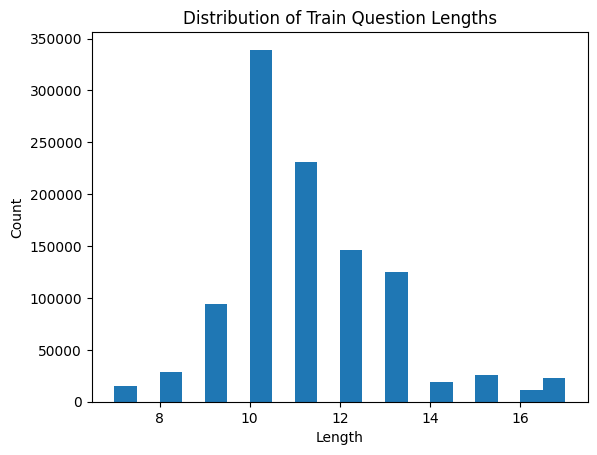

In [54]:
#Test lengths of Questions
token_lens2 = []

for txt in train_question:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Train Question Lengths');

TEST-DATA

17
10807


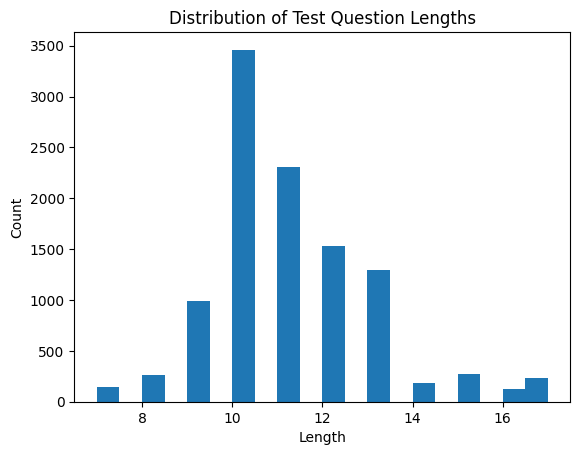

In [55]:
#Test lengths of Questions
token_lens2 = []

for txt in test_question:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Test Question Lengths');